# Purpose

Using the Intel `convert` tool, I'm examining the output of the CSV produced using: `./rs-convert -i ~/Documents/baseline.bag -p output/hello -v output/hello`. 

The `-p` flag converts to PNG, and `-v` converts it to CSV.

In this notebook I examine the `baseline.bag` file.

In [1]:
# allow us to import files from `src` dir

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

### where's the face

In [2]:
COLOUR_IMAGE_PATH = 'output/hello_Color_471.png'

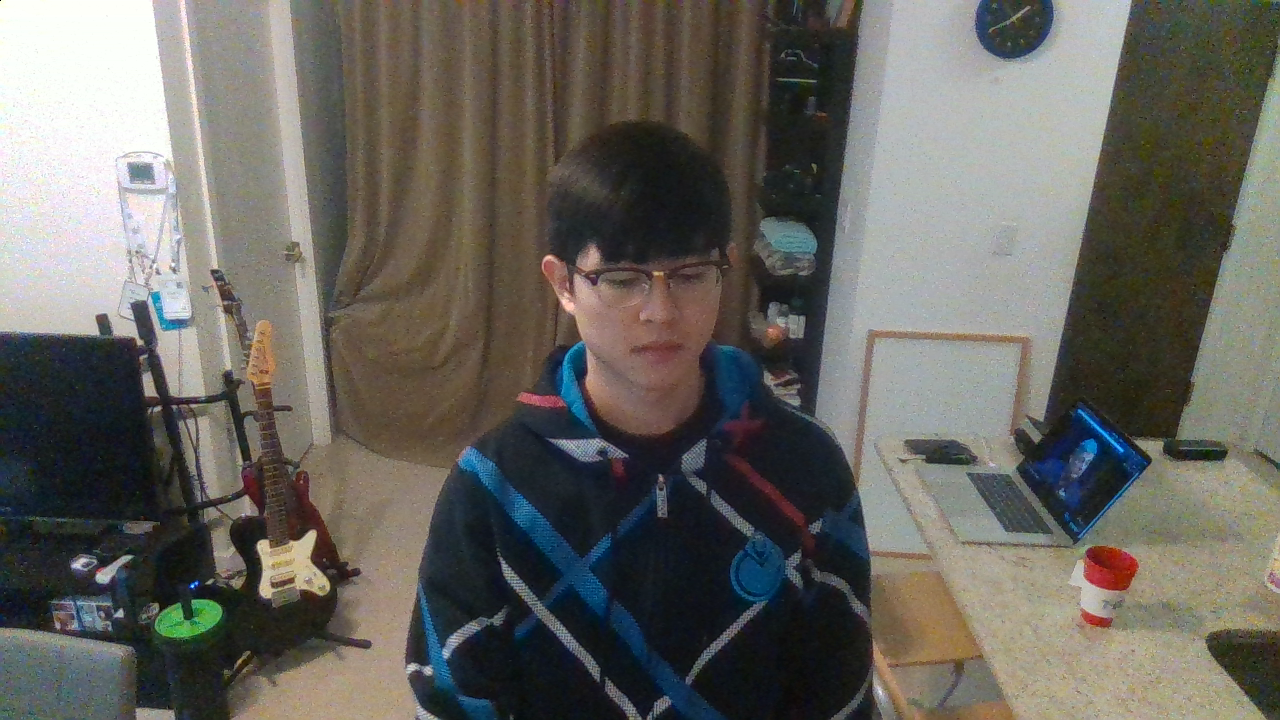

In [3]:
from IPython.display import Image
Image(filename=COLOUR_IMAGE_PATH)

From above, extract the bounding boxes of the face.

In [17]:
import cv2
from PIL import Image
import numpy as np

from src.face_detect import face_detect

img = cv2.imread(COLOUR_IMAGE_PATH)
bbox = face_detect(img)

In [5]:
bbox

[571, 215, 743, 387]

Verify that the bounding box was drawn correctly.

In [6]:
def draw_box(image, bbox):
    """return a picture with bounding box overlayed"""
    min_x, min_y, max_x, max_y = bbox
    
    bgr_colour = (0, 255, 0)
    thickness = 3
    
    new_img = cv2.rectangle(
        image, 
        (min_x, min_y), 
        (max_x, max_y), 
        bgr_colour, 
        thickness
    )
    
    return new_img

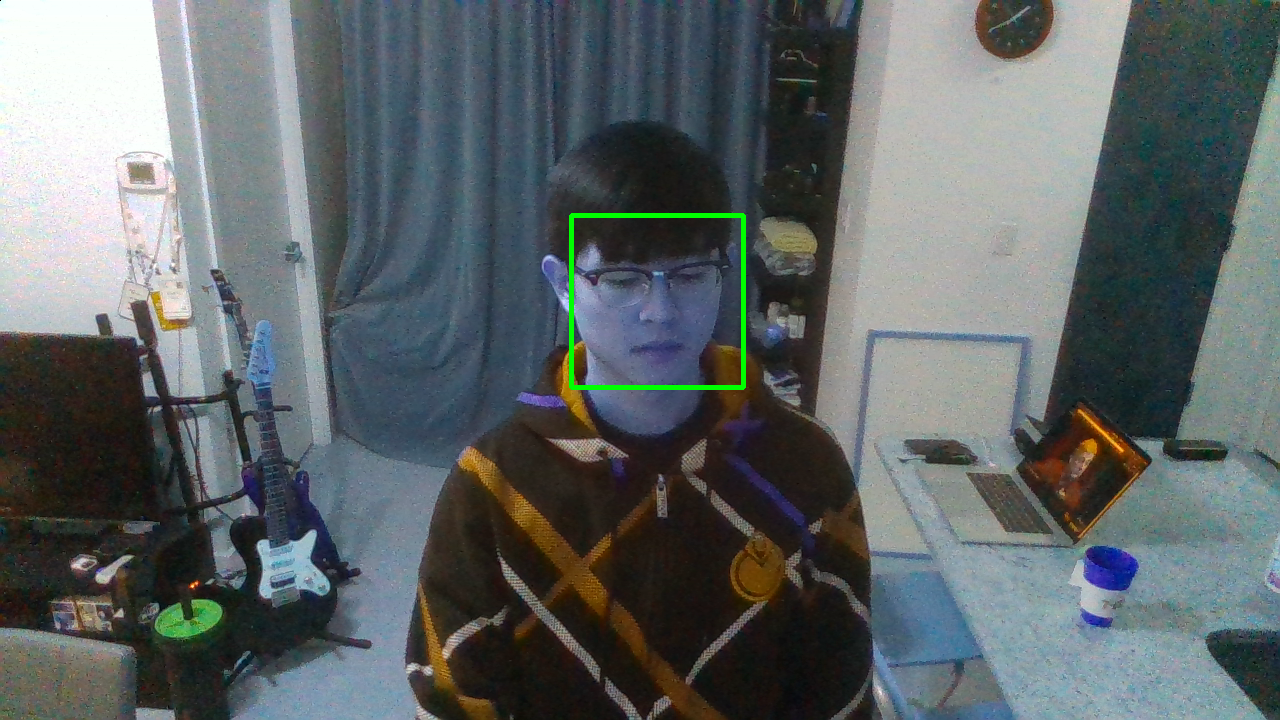

In [7]:
Image.fromarray(draw_box(img, bbox), 'RGB')

Above picture will be a little bit blue because the channels get flipped around from `RGB` to `BGR`.

### Get depth

Now that we have the bounding box around the face, let's get the depth of the face from the CSV. Picture below is what we're working with.

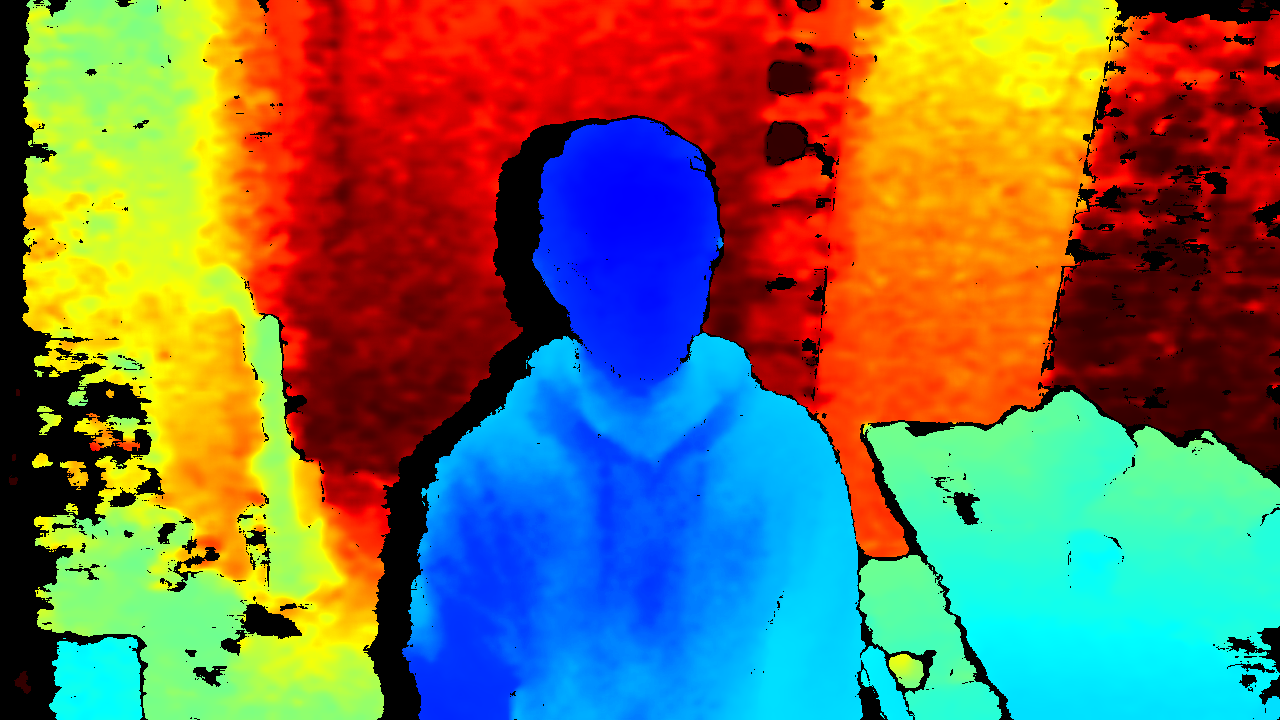

In [8]:
from IPython.display import Image
Image(filename='output/hello_Depth_514.png')

In [9]:
import pandas as pd
df = pd.DataFrame.from_csv('output/hello_Depth_514.csv')

Below is what the CSV file sort of looks like.

In [10]:
df.head()

0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  0.10  ...    0.262  0.263  \
0                                                     ...                   
0    0    0    0    0    0    0    0    0  0.0   0.0  ...      0.0    0.0   
0    0    0    0    0    0    0    0    0  0.0   0.0  ...      0.0    0.0   
0    0    0    0    0    0    0    0    0  0.0   0.0  ...      0.0    0.0   
0    0    0    0    0    0    0    0    0  0.0   0.0  ...      0.0    0.0   
0    0    0    0    0    0    0    0    0  0.0   0.0  ...      0.0    0.0   

   0.264  0.265  0.266  0.267  0.268  0.269  0.270  0.271  
0                                                          
0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  
0    0.0    0.0    0.0    0.0    0.0    0.0    0.0    0.0  

[5 rows x 1279 columns]

It's a 720 row x 1280 column DF.

In [11]:
df.shape

(719, 1279)

Let's get the depth values at the area within the bounding box.

In [12]:
min_x, min_y, max_x, max_y = bbox

Now that we have the indexed version of the depth values for the area that we think is the face, let's get an average value of all of the values of the DF.

In [13]:
np.min(df.values)

0.0

In [14]:
np.max(df.values)

25.998

In [15]:
face_depths = df.iloc[min_y:max_y, min_x:max_x]

np.mean(face_depths.values)

1.3116348025959979

So we're looking at something like 1.31 meters away from the camera (in our case, the shelf).

### Face angle

The face angle will give us the norm of the shelf. We should make sure that the face is actually looking at the shelf straight-on.

In [18]:
from src.gazenet import Gazenet
from src.calibrate import get_shelf_plane_norm

In [19]:
GAZENET_PATH = '../models/gazenet/hopenet_robust_alpha1.pkl'

g = Gazenet(GAZENET_PATH)
img = cv2.imread(COLOUR_IMAGE_PATH)
get_shelf_plane_norm(g, img)

/usr/local/lib/python3.6/site-packages/torchvision/transforms/transforms.py:188: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.
  "please use transforms.Resize instead.")
/Users/wonjunetai/src/github.com/vendlytics/src/gazenet.py:33: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  yaw_pred = F.softmax(yaw)
/Users/wonjunetai/src/github.com/vendlytics/src/gazenet.py:34: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  pitch_pred = F.softmax(pitch)
/Users/wonjunetai/src/github.com/vendlytics/src/gazenet.py:35: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  roll_pred = F.softmax(roll)


array([ 0.66563129, -0.16963032,  0.72674654])

Verify that the face angle that came out is correct.

In [21]:
def draw_face_angle_on_image(image, bbox, angles):
    # look at how hopenet's demo drew them.
    pass